In [79]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

In [80]:
model_params = [16709, 24837, 49413, 3470821, 28000000, 200000000, 681000000]
model_labels = ["CONCH (embeddings)", "CTransPath (embeddings)", "UNI (embeddings)", "eCaReNet", "CTransPath (full)", "CONCH (full)", "UNI (full)"]

In [81]:
def simulate_fl_communication():
    bandwidths = {
        "10 Mbps": 10 * 10**6, 
        "100 Mbps": 100 * 10**6, 
        "1 Gbps": 1000 * 10**6
    } # https://cerre.eu/wp-content/uploads/2024/09/CERRE_The-Future-of-European-Telecommunications-In-depth-Analysis_FINAL.pdf
    
    # just using min and max of paper
    latencies_ms = [0, 200] # https://www.sciencedirect.com/science/article/pii/S0167739X23000663

    results = list()
    for p, label in zip(model_params, model_labels):
        for bw_name, bw_bps in bandwidths.items():
            for lat in latencies_ms:
                lat_sec = lat / 1000.0 # convert to seconds
                total_bits = p * 32 # Bits to transfer (params * 32 bits per param)
                transfer_time = total_bits / bw_bps
                
                # Total Round Trip (2 * Upload + 2 * Download)
                # Client and aggregator are both sending and receiving twice
                total_time = 4 * (transfer_time + lat_sec)
                
                results.append({
                    "Model": label,
                    "Params": p,
                    "Bandwidth": bw_name,
                    "Round_Time_sec": round(total_time, 4)
                })

    return pd.DataFrame(results)

df = simulate_fl_communication()

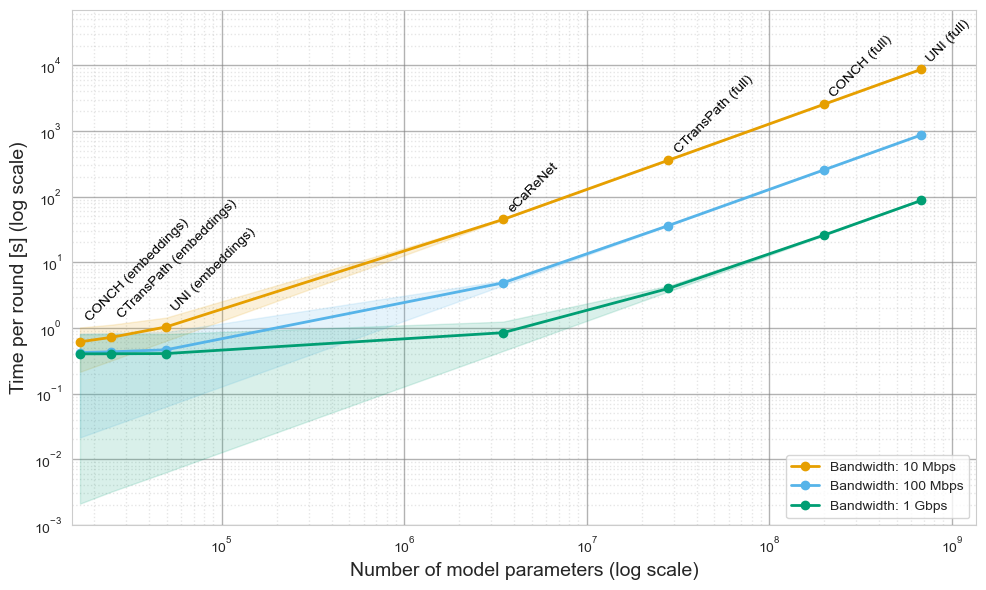

In [83]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = {"10 Mbps": "#E69F00", "100 Mbps": "#56B4E9", "1 Gbps": "#009E73"}
for bw in df["Bandwidth"].unique():
    subset = df[df["Bandwidth"] == bw]
    stats = subset.groupby("Params")["Round_Time_sec"].agg(["min", "max", "mean"]).reset_index()
    ax.plot(stats["Params"], stats["mean"], label=f"Bandwidth: {bw}", color=colors[bw], marker="o", linewidth=2)
    ax.fill_between(stats["Params"], stats["min"], stats["max"], color=colors[bw], alpha=0.15)

ax.set_xscale("log")
ax.set_yscale("log")
param_to_label = dict(zip(model_params, model_labels))
for p in df["Params"].unique():
    y_pos = df[df["Params"] == p]["Round_Time_sec"].max()
    ax.annotate(param_to_label[p], xy=(p, y_pos), xytext=(2.5, 5),textcoords="offset points", rotation=45, fontsize=10, color="black")

ax.set_ylim(top=df["Round_Time_sec"].max() * 8)
ax.set_xlim(left=model_params[0]*0.9, right=model_params[-1]*2)
ax.set_xlabel("Number of model parameters (log scale)", fontsize=14)
ax.set_ylabel("Time per round [s] (log scale)", fontsize=14)
ax.grid(True, which="major", ls="-", color="gray", alpha=0.6, linewidth=1)
ax.grid(True, which="minor", ls=":", color="gray", alpha=0.2, linewidth=1)
ax.legend(loc="lower right", fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join("communication_overhead", f"simulation_communication_overhead.png"), dpi=600)